In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from typing import List
from tqdm import tqdm

from envs.utils.PositionConstraint import PositionConstraint

In [2]:
geoFence = PositionConstraint(0, 2, -0.5, 0.5, 0, 1)

In [35]:
class SkeletonAviary:

    CLOSE_TO_FINISH_REWARD = 5
    SUCCESS_REWARD = 1
    COLLISION_PENALTY = -5

    SUCCESS_EPSILON = 0.1

    MINOR_SAFETY_BOUND_RADIUS = 0.2
    MAJOR_SAFETY_BOUND_RADIUS = 0.1 
    COLLISION_BOUND_RADIUS = 0.07

    def __init__(self, geoFence:PositionConstraint, obstacles:List[np.ndarray]=[], defaultAltitude:float=0.5):

        self.geoFence = geoFence
        self.defaultAltitude = defaultAltitude
        
        for obstacle in obstacles:
            assert self.geoFence.inBounds(obstacle), "Given Obstacle is not in Bounds"

        self.obstacles = obstacles

        self.targetPos = np.array([self.geoFence.xmax - SkeletonAviary.MINOR_SAFETY_BOUND_RADIUS, (self.geoFence.ymin + self.geoFence.ymax)/2, defaultAltitude])

    
    def visualizeRewardSurface(self):

        X = np.arange(self.geoFence.xmin, self.geoFence.xmax, 0.005)
        Y = np.arange(self.geoFence.ymin, self.geoFence.ymax, 0.005)
        Z = []

        XX = []
        YY = []

        for x in tqdm(X):
            XX.append([])
            YY.append([])
            Z.append([])

            for y in Y:
                XX[-1].append(x)
                YY[-1].append(y)
                Z[-1].append(self.computeReward(np.array([x, y, self.defaultAltitude])))

        X = np.array(XX)
        Y = np.array(YY)        
        Z = np.array(Z)
        
        plt.figure(figsize=(15, 15))
        ax = plt.axes(projection='3d', elev=30, azim=145)
        surf = ax.plot_surface(X, Y, Z, cmap=cm.magma,
                       linewidth=0, antialiased=True)

        ax.set_xlim(self.geoFence.xmin, self.geoFence.xmax)
        ax.set_ylim(self.geoFence.ymin*2, self.geoFence.ymax*2)

        ax.set_xticks(np.arange(self.geoFence.xmin, self.geoFence.xmax + 0.2, 0.2))
        ax.set_yticks(np.arange(2*self.geoFence.ymin, 2*self.geoFence.ymax + 0.2, 0.2))

        ax.set_xlabel("X axis")
        ax.set_ylabel("Y axis")
        ax.set_zlabel("Reward (Adjusted)")

        plt.gcf().colorbar(surf, fraction=0.046, pad=0.04)
        plt.savefig('rewardFunction.png')
        plt.show()

    def _computeOffsetToClosestObstacle(self, pos):

        x,y,z = pos
        # Check distance to all obstacles
        obstacleOffset = None
        
        for obstacle in self.obstacles:
            offset = obstacle - pos

            if obstacleOffset is None:
                obstacleOffset = offset
            else:
                obstacleOffset = min(obstacleOffset, offset, key=np.linalg.norm)


        # Check distance to boundaries
        xBoundDist = min(x - self.geoFence.xmin, self.geoFence.xmax - x)
        yBoundDist = min(y - self.geoFence.ymin, self.geoFence.ymax - y)
        zBoundDist = min(z - self.geoFence.zmin, self.geoFence.zmax - z)
        

        boundDists = [xBoundDist, yBoundDist, zBoundDist]

        if xBoundDist == min(boundDists):
            if x - self.geoFence.xmin < self.geoFence.xmax - x:
                fenceOffset = np.array([-(x - self.geoFence.xmin), 0, 0])
            else:
                fenceOffset = np.array([(self.geoFence.xmax - x), 0, 0])

        elif yBoundDist == min(boundDists):
            if y - self.geoFence.ymin < self.geoFence.ymax - y:
                fenceOffset = np.array([0, -(y - self.geoFence.ymin), 0])
            else:
                fenceOffset = np.array([0, (self.geoFence.ymax - y), 0])
        else:
            if z - self.geoFence.zmin < self.geoFence.zmax - z:
                fenceOffset = np.array([0, 0, -(z - self.geoFence.zmin)])
            else:
                fenceOffset = np.array([0, 0, (self.geoFence.zmax - z)])

        return fenceOffset if obstacleOffset is None else min(fenceOffset, obstacleOffset, key=np.linalg.norm) 

    def computeReward(self, pos):
        
        if np.linalg.norm(self.targetPos - pos) < SkeletonAviary.SUCCESS_EPSILON:
            return SkeletonAviary.SUCCESS_REWARD
        
        offsetToClosestObstacle = self._computeOffsetToClosestObstacle(pos)

        distToClosestObstacle = np.linalg.norm(offsetToClosestObstacle)

        if distToClosestObstacle < SkeletonAviary.COLLISION_BOUND_RADIUS:
            return SkeletonAviary.COLLISION_PENALTY
        
        majorBreach = distToClosestObstacle < SkeletonAviary.MAJOR_SAFETY_BOUND_RADIUS
        minorBreach = distToClosestObstacle < SkeletonAviary.MINOR_SAFETY_BOUND_RADIUS

        return -4*np.linalg.norm(self.targetPos - pos) - 5*majorBreach -1*minorBreach


In [36]:
# obstacles = np.array([
#     [1.0, 0.0, 0.5]
# ])

obstacles = np.array([
    [0.7, -0.2, 0.5],
    [1.3, 0.2, 0.5],
])

In [37]:
env = SkeletonAviary(geoFence, obstacles)

100%|██████████| 400/400 [00:03<00:00, 123.83it/s]


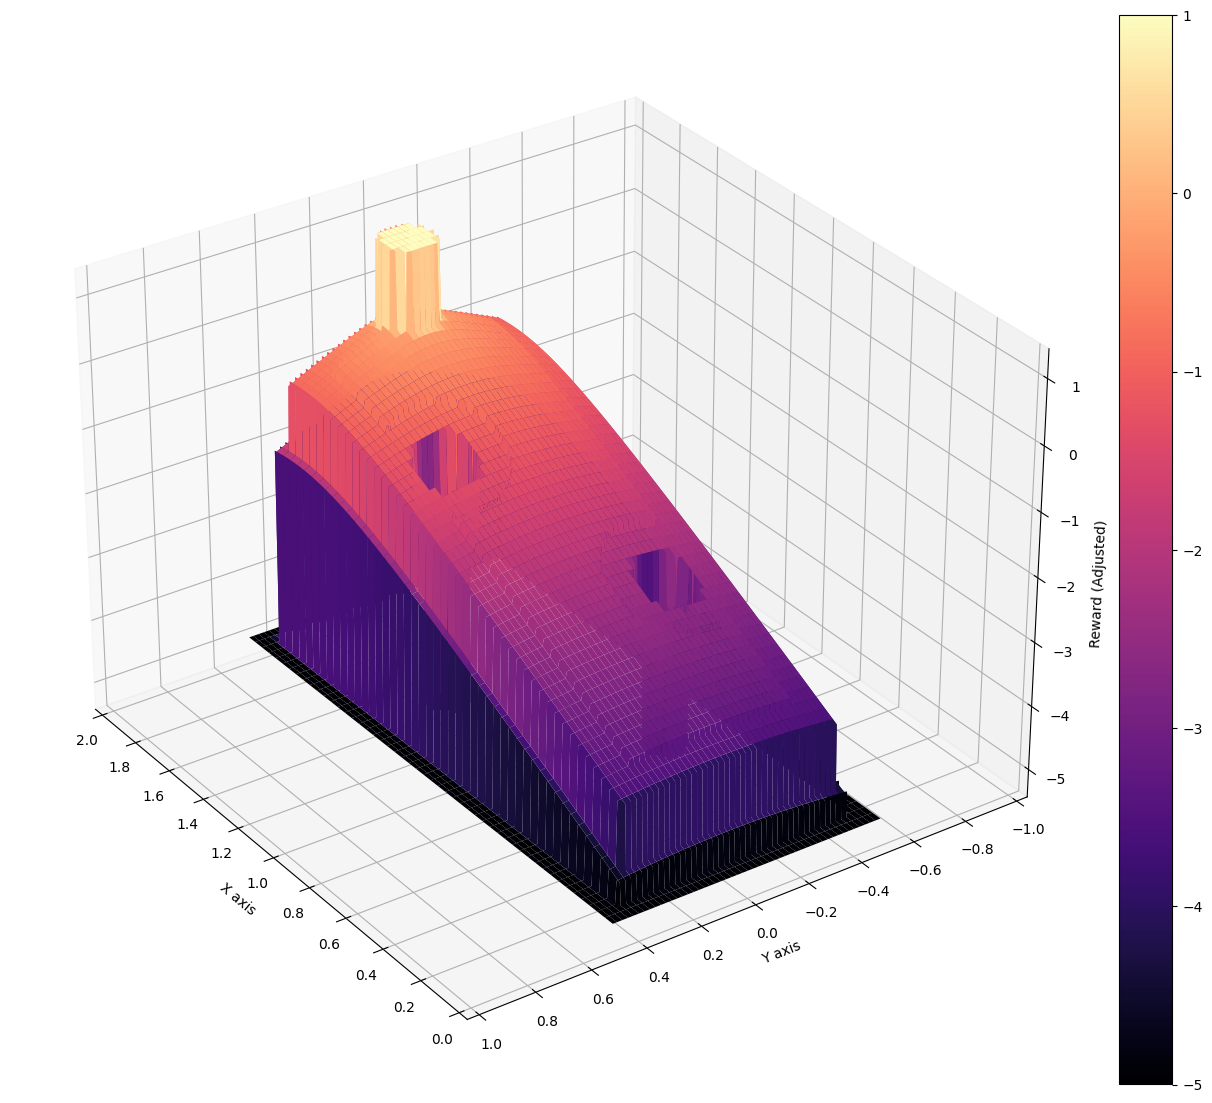

In [38]:
env.visualizeRewardSurface()